In [164]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.stats import multivariate_normal
import pandas as pd
import sklearn


import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Layer, Dropout, BatchNormalization, LeakyReLU, Lambda
from keras.losses import Loss, binary_crossentropy, mean_squared_error, MeanSquaredError
from keras.optimizers import Optimizer, Adam, RMSprop
from keras.metrics import Mean, RootMeanSquaredError
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, plot_model, load_img, img_to_array
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

import tensorflow_probability as tfp

# PINN:Boltzmann-BGK

# Automatic Diff: Layer

In [165]:
class AutomaticDiff(Layer):
    def __init__(self, maxwell_distribution, tau, name = 'AutomaticDiff'):
        """
        Initialize the AutomaticDiff layer.

        Args:
            maxwell_distribution: A MaxwellDistribution model instance.
            tau: A scalar value representing the relaxation time.
        """
        super().__init__(name = name)
        
        self.maxwell_distribution = maxwell_distribution
        self.tau = tau

    def call(self, inputs):
        
        """
        Compute the residual R and the combined distribution f for the given inputs.

        Args:
            inputs: A tuple (x_train, y_train), where:
                    x_train: A tensor of shape (batch_size, 2), containing x and y spatial coordinates.
                    y_train: A tensor of shape (batch_size, 3), containing u and v velocity components and the pressure p.

        Returns:
            R: A tensor of shape (batch_size, 3, 1), representing the residual.
            f: A tensor of shape (batch_size, 3), representing the combined distribution.
        """
        x_train, y_train = inputs 
        # x_train : (batch_size, 2)

        # Calculate the equilibrium (f_eq) and non-equilibrium (f_neq) distributions from the Maxwell distribution
        with tf.GradientTape(persistent = True) as g:
            g.watch(x_train)
            f_eq, f_neq = self.maxwell_distribution(x_train)
            f = f_eq + f_neq   # Combine f_eq and f_neq to get f (shape: (batch_size, 3))
        
        # Compute the batch Jacobian of f with respect to x_train
        dfdx_dfdy = g.batch_jacobian(f, x_train)

        # Extract the partial derivatives with respect to x and y
        dfdx = tf.squeeze(dfdx_dfdy[:,:,0:1], axis = -1)  # shape: (batch_size, 3)
        dfdy =  tf.squeeze(dfdx_dfdy[:,:,1:2], axis = -1) # shape: (batch_size, 3)
        #print('dfdx', dfdx)

        # Separate the u and v velocity components from the y_train tensor
        u = y_train[:,:1]  # shape: (batch_size, 1)
        v = y_train[:,1:2] # shape: (batch_size, 1)

        # Compute the residual R using the velocity components and the partial derivatives
        R = u*dfdx + v*dfdy + f_neq/self.tau  # shape: (batch_size, 3, 1)
        #print('R', R)

        return R, f 


# Add Loss: Layer

In [166]:
class AddLoss(Layer):
    def __init__(self):
        """
        Initialize the AddLoss layer.
        This layer is responsible for computing a custom loss function that combines
        the mean squared error (MSE) of the true and predicted macroscopic variables
        with the mean squared error of the residual tensor.
        """
        super().__init__()

    def call(self, residual, y_true, y_pred):
        """
        Compute and add the custom loss to the layer.

        Args:
            residual: A tensor of shape (batch_size, 3), representing the residual computed in the AutomaticDiff layer.
            y_true: A tensor of shape (batch_size, 3), containing the true macroscopic variables (u, v, p).
            y_pred: A tensor of shape (batch_size, 3), containing the predicted macroscopic variables (u, v, p).
        
        Returns:
            y_pred: The input y_pred tensor is returned unchanged, allowing this layer to be easily inserted into the model.
        """
        self.add_loss(self.custom_loss(residual, y_true, y_pred))
        return y_pred
    
    def custom_loss(self, residual, y_true, y_pred):
        """
        Compute the custom loss function.
        
        Args:
            residual: A tensor of shape (batch_size, 3), representing the residual computed in the AutomaticDiff layer.
            y_true: A tensor of shape (batch_size, 3), containing the true macroscopic variables (u, v, p).
            y_pred: A tensor of shape (batch_size, 3), containing the predicted macroscopic variables (u, v, p).
        
        Returns:
            loss: A scalar tensor representing the combined loss, calculated as the sum of the mean squared error (MSE)
                  between the true and predicted macroscopic variables and the mean squared error of the residual tensor.
        """
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        residual_mse = tf.reduce_mean(tf.square(residual))
        loss = mse + residual_mse
        return loss


# Prior and Posterior: Layers

In [167]:
class PriorLayer(Layer):
    def __init__(self, kernel_size, bias_size, dtype=None):
        """
        Initialize the PriorLayer.

        Args:
            kernel_size: An integer representing the size of the kernel.
            bias_size: An integer representing the size of the bias.
            dtype: Optional, the data type of the layer.
        """
        super().__init__()

        self.kernel_size = kernel_size
        self.bias_size = bias_size
        n = self.kernel_size + self.bias_size

        # Create a prior distribution with MultivariateNormalDiag.
        # MultivariateNormalDiag represents a diagonal multivariate normal distribution,
        # which assumes no correlation between the dimensions.
        prior = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))
        
        # Wrapper: Convert distribution object to be used in a Keras model.
        # DistributionLambda is used to wrap a custom TensorFlow Probability distribution
        # into a Keras layer.
        self.wrapper_prior = tfp.layers.DistributionLambda(lambda _: prior)

    def call(self, _):
        """
        Compute the prior distribution for the given dummy input.

        Args:
            _: A dummy input tensor. The actual value of this tensor does not affect the output.
        
        Returns:
            x: A MultivariateNormalDiag distribution representing the prior distribution.
        """
        # In the call method, we pass the dummy input _ to the wrapper_prior.
        # The output will be the prior distribution.
        x = self.wrapper_prior(_)
        return x


In [168]:
class PosteriorLayer(Layer):
    def __init__(self, kernel_size, bias_size, dtype=None):
        """
        Initialize the PosteriorLayer.

        Args:
            kernel_size: An integer representing the size of the kernel.
            bias_size: An integer representing the size of the bias.
            dtype: Optional, the data type of the layer.
        """
        super(PosteriorLayer, self).__init__()
        self.kernel_size = kernel_size
        self.bias_size = bias_size
        n = self.kernel_size + self.bias_size

        # Instantiate the VariableLayer with the necessary number of parameters
        # for the IndependentNormal distribution.
        self.variable_layer = tfp.layers.VariableLayer(
            tfp.layers.IndependentNormal.params_size(n), dtype=dtype
        )

        # Create an instance of the IndependentNormal layer with the required
        # total number of parameters (kernel_size + bias_size).
        self.independent_normal = tfp.layers.IndependentNormal(n, activity_regularizer=None)

    def call(self, _):
        """
        Compute the posterior distribution for the given dummy input.

        Args:
            _: A dummy input tensor. The actual value of this tensor does not affect the output.
        
        Returns:
            posterior: An IndependentNormal distribution representing the posterior distribution.
        """
        # Generate the parameters for the IndependentNormal distribution
        # using the VariableLayer. The _ is just a dummy variable to
        # activate the call method of the VariableLayer.
        params = self.variable_layer(_)

        # Create a new instance of the IndependentNormal distribution with
        # the generated parameters and return it.
        posterior = self.independent_normal(params)
        return posterior


# Dense Neural Network (DNN): Model

In [169]:
class DNN(Layer):
    def __init__(self,
                 layer_units: list = [20, 20],
                 output_unit: int = 3,
                 activation_func: str = 'tanh',
                 initializer: str = "glorot_normal",
                 name="DNN"):
        """
        Initialize the DNN (Deep Neural Network) layer.

        Args:
            layer_units: A list of integers representing the number of units in each hidden layer .
            output_unit: An integer representing the number of units in the output layer .
            activation_func: A string representing the activation function used in the hidden layers .
            initializer: A string representing the kernel initializer used for the layers .
            name: A string representing the name of the layer.
        """
        super().__init__(name=name)

        self.units = layer_units
        self.output_unit = output_unit
        self.activation_func = activation_func
        self.initializer = initializer

        # Hidden layers
        self.hidden_layer = []
        count = 0
        for unit in layer_units:
            self.hidden_layer.append(Dense(units=unit,
                                           kernel_initializer=self.initializer,
                                           activation=activation_func,
                                           name='Hidden_{}'.format(count)))
            count += 1

        # Output layer
        self.output_layer = Dense(units=output_unit,
                                  kernel_initializer=self.initializer,
                                  name="Output")

    def call(self, x):
        """
        Compute the forward pass of the DNN layer.

        Args:
            x: A tensor of shape (batch_size, input_dim), where input_dim is the dimension of the input features.

        Returns:
            x: A tensor of shape (batch_size, output_unit), containing the output of the DNN layer.
        """
        # Pass the input through the hidden layers
        for hidden in self.hidden_layer:
            x = hidden(x)

        # Pass the output of the hidden layers through the output layer
        x = self.output_layer(x)

        return x


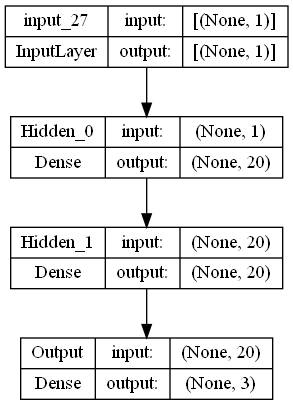

In [170]:
input = Input(shape = (1,))
dnn = DNN()

model = Model(inputs =input, outputs = dnn.call(input))
plot_model(model, show_shapes=True, show_layer_names=True)

# Bayesian Neural Network (BNN): Model

In [171]:
class BNN(Layer):
    def __init__(self,
                 layer_units: list = [8, 8],
                 output_unit: int = 3,
                 activation_func: str = "sigmoid",
                 kl_weight: float = 1e-3,
                 name="BNN"):
        """
        Initialize the BNN (Bayesian Neural Network) layer.

        Args:
            layer_units: A list of integers representing the number of units in each hidden layer (default: [8, 8]).
            output_unit: An integer representing the number of units in the output layer (default: 3).
            activation_func: A string representing the activation function used in the hidden layers (default: 'sigmoid').
            kl_weight: A float representing the weight of the KL divergence term in the loss (default: 1e-3).
            name: A string representing the name of the layer (default: 'BNN').
        """
        super().__init__(name=name)

        self.layer_units = layer_units
        self.output_unit = output_unit
        self.activation_func = activation_func
        self.kl_weight = kl_weight

        self.batch_normalization = BatchNormalization(name="BatchNormalization")
        self.dense_var_layer = []
        for count, units in enumerate(layer_units):
            self.dense_var_layer.append(tfp.layers.DenseVariational(units=units,
                                                                     make_posterior_fn=self.make_posterior_fn,
                                                                     make_prior_fn=self.make_prior_fn,
                                                                     kl_weight=kl_weight,
                                                                     activation=activation_func,
                                                                     name='DenseVariational_{}'.format(count))
                                         )
        self.output_layer = tfp.layers.DenseVariational(units=self.output_unit,
                                                        make_posterior_fn=self.make_posterior_fn,
                                                        make_prior_fn=self.make_prior_fn,
                                                        kl_weight=self.kl_weight,
                                                        activation=None,
                                                        name='OutputLayer')

    def make_posterior_fn(self, kernel_size, bias_size, dtype=None):
        """
        Creates a posterior function with the given kernel_size, bias_size, and dtype.

        Args:
            kernel_size: An integer representing the size of the kernel.
            bias_size: An integer representing the size of the bias.
            dtype: Data type of the layers.

        Returns:
            A PosteriorLayer instance with the specified parameters.
        """
        return PosteriorLayer(kernel_size, bias_size, dtype)

    def make_prior_fn(self, kernel_size, bias_size, dtype=None):
        """
        Creates a prior function with the given kernel_size, bias_size, and dtype.

        Args:
            kernel_size: An integer representing the size of the kernel.
            bias_size: An integer representing the size of the bias.
            dtype: Data type of the layers.

        Returns:
            A PriorLayer instance with the specified parameters.
        """
        return PriorLayer(kernel_size, bias_size, dtype)

    def call(self, x):
        """
        Compute the forward pass of the BNN layer.

        Args:
            x: A tensor of shape (batch_size, input_dim), where input_dim is the dimension of the input features.

        Returns:
            x: A tensor of shape (batch_size, output_unit), containing the output of the BNN layer.
        """
        x = self.batch_normalization(x)
        for dense_var_layer in self.dense_var_layer:
            x = dense_var_layer(x)
        x = self.output_layer(x)
        return x


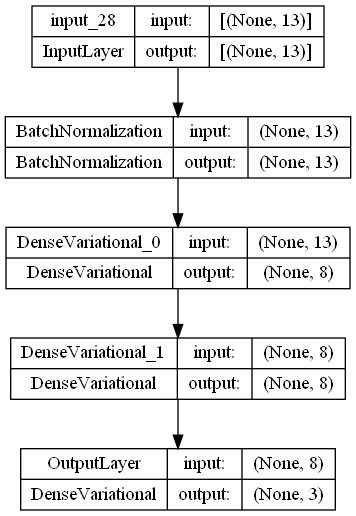

In [172]:
input = Input(shape = (13,))
bnn = BNN()

model = Model(inputs =input, outputs = bnn.call(input))
plot_model(model, show_shapes=True, show_layer_names=True)

# Dual BNN: Model

In [173]:
class MaxwellDistribution(Layer):
    def __init__(self, bnn_1, bnn_2, name="DualBNN"):
        """
        Initialize the MaxwellDistribution layer.

        Args:
            bnn_1: A BNN (Bayesian Neural Network) instance representing the equilibrium distribution.
            bnn_2: A BNN (Bayesian Neural Network) instance representing the non-equilibrium distribution.
            name: A string representing the name of the layer.
        """
        super().__init__(name=name)

        self.bnn_1 = bnn_1
        self.bnn_2 = bnn_2

    def call(self, inputs):
        """
        Compute the forward pass of the MaxwellDistribution layer.

        Args:
            inputs: A tensor of shape (batch_size, input_dim), where input_dim is the dimension of the input features.

        Returns:
            f_eq: A tensor containing the equilibrium distribution of the Maxwell distribution.
            f_neq: A tensor containing the non-equilibrium distribution of the Maxwell distribution.
        """
        f_eq = self.bnn_1(inputs)
        f_neq = self.bnn_2(inputs)
        return f_eq, f_neq


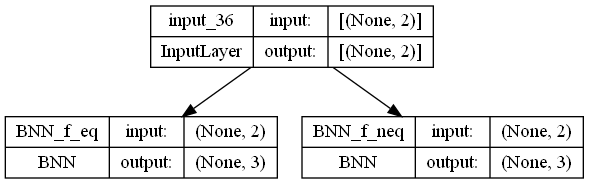

In [189]:
input = Input(shape = (2,))
bnn_1 = BNN(name = "BNN_f_eq")
bnn_2 = BNN(name = "BNN_f_neq")
maxwell_dist = MaxwellDistribution(bnn_1, bnn_2 )

model = Model(inputs =input, outputs = maxwell_dist.call(input))
plot_model(model, show_shapes=True, show_layer_names=True)

# Bayesian Physical Informed Neural Network (BPINN): Model

In [174]:
class BPINN(Model):
    def __init__(self, bnn_1, bnn_2, dnn, tau=1.58e-4):
        """
        Initialize the BPINN (Bayesian Physics-informed Neural Network) model.

        Args:
            bnn_1: A Bayesian Neural Network instance for equilibrium distribution.
            bnn_2: A Bayesian Neural Network instance for non-equilibrium distribution.
            dnn: A Deep Neural Network instance for macroscopic variables.
            tau: A scalar value representing the relaxation time.
        """
        super(BPINN, self).__init__()

        # Initialize layers and models
        self.maxwell_dist_model = MaxwellDistribution(bnn_1, bnn_2)
        self.autodiff_layer = AutomaticDiff(self.maxwell_dist_model, tau)
        self.addloss_layer = AddLoss()
        self.dnn = dnn

    def call(self, inputs):
        """
        Compute the forward pass of the BPINN model.

        Args:
            inputs: A tuple (x_train, y_train), where:
                    x_train: A tensor of shape (batch_size, 2), containing x and y spatial coordinates.
                    y_train: A tensor of shape (batch_size, 3), containing u and v velocity components and the pressure p.

        Returns:
            f: A tensor of shape (batch_size, 3), representing the combined distribution.
            y_pred: A tensor of shape (batch_size, 3), containing the predicted macroscopic variables (u, v, and p).
        """
        x_train, y_train = inputs

        # Calculate the residual, equilibrium, and non-equilibrium distributions from the BNNs using AutomaticDiff
        residual, f = self.autodiff_layer(inputs)

        # Compute the macroscopic variables using the DNN (u, v, and p)
        y_pred = self.dnn(f)

        # Calculate the loss
        y_pred = self.addloss_layer(residual, y_train, y_pred)

        return f, y_pred


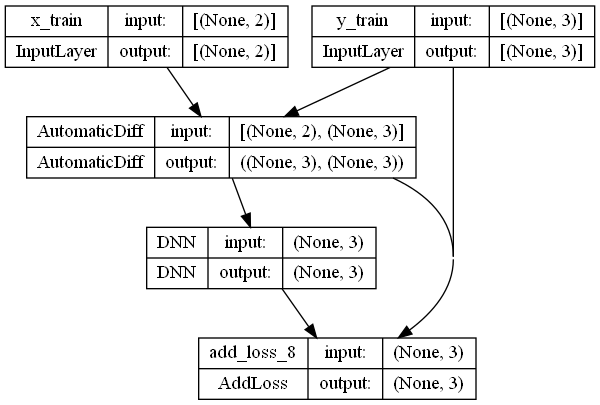

In [175]:
input = [Input(shape = (2,), name = 'x_train'), Input(shape = (3,), name ='y_train')]
bnn_1 = BNN()  # working
bnn_2 = BNN()   # working
dnn = DNN()    # working

bpinn = BPINN(bnn_1, bnn_2, dnn)

model = Model(inputs = input, outputs = bpinn.call(input))
plot_model(model, show_shapes=True, show_layer_names=True)

# Main

In [177]:
def kovasznay_flow(x, y, u_0 = 0.1581, p_0 = 0.05, RT = 100, L = 1, Re = 10):

    # Calculate lambda
    Lambda = Re / 2 - np.sqrt(Re ** 2 / 4 + 4 * np.pi ** 2)
    
    # Calculate the velocity components u and v
    u = u_0 * (1 - np.exp(Lambda * x) * np.cos(2 * np.pi * y))
    v = u_0 * (Lambda / (2 * np.pi) * np.exp(Lambda * x) * np.sin(2 * np.pi * y))
    
    # Calculate the pressure p
    p = p_0 * (1 - np.exp(2 * Lambda * x)) + RT
    
    return u, v, p

In [178]:
# Define the rectangular domain
x_min, x_max = -1/2, 2
y_min, y_max = -1/2, 3/2

# Number of random points for evaluation of residuals
residual_points = 1000

# Generate random points inside the boundary
x = np.random.uniform(x_min, x_max, residual_points)
y = np.random.uniform(y_min, y_max, residual_points)
xy = np.column_stack((x, y))

u, v, p = kovasznay_flow(x, y)
uvp = np.column_stack((u, v, p))

# Number of random points on each boundary for Dirichlet boundary conditions
boundary_points = 300

# Generate random points specifically on the boundaries
x_left = np.ones(boundary_points) * x_min
y_left = np.random.uniform(y_min, y_max, boundary_points)

x_right = np.ones(boundary_points) * x_max
y_right = np.random.uniform(y_min, y_max, boundary_points)

x_top = np.random.uniform(x_min, x_max, boundary_points)
y_top = np.ones(boundary_points) * y_max

x_bottom = np.random.uniform(x_min, x_max, boundary_points)
y_bottom = np.ones(boundary_points) * y_min

# Combine all boundary points
x_boundary = np.hstack((x_left, x_right, x_top, x_bottom))
y_boundary = np.hstack((y_left, y_right, y_top, y_bottom))

xy_bdr = np.column_stack((x_boundary, y_boundary))
u_bdr, v_bdr, p_bdr = kovasznay_flow(x_boundary, y_boundary)
uvp_bdr = np.column_stack((u_bdr, v_bdr, p_bdr))

x_train = [xy, xy_bdr]
y_train = [uvp, uvp_bdr]

x_train_combined = np.vstack(x_train)
y_train_combined = np.vstack(y_train)

data_train = [x_train_combined, y_train_combined]

In [191]:
bnn_1 = BNN()  
bnn_2 = BNN() 
dnn = DNN()   

bpinn = BPINN(bnn_1, bnn_2 , dnn) 

bpinn.compile( optimizer = tf.optimizers.Adam(learning_rate=0.001))
history = bpinn.fit(x = data_train, epochs= 5, batch_size=32)

Epoch 1/5
69/69 [==============================] - 5s 1ms/step - loss: 66323804.0000
Epoch 2/5
69/69 [==============================] - 0s 2ms/step - loss: 66254248.0000
Epoch 3/5
69/69 [==============================] - 0s 2ms/step - loss: 56586048.0000
Epoch 4/5
69/69 [==============================] - 0s 2ms/step - loss: 41448920.0000
Epoch 5/5
69/69 [==============================] - 0s 2ms/step - loss: 45955888.0000


## Plots

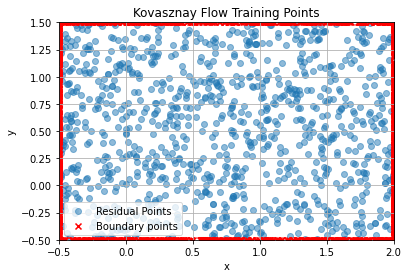

In [181]:
# Plot the random points inside the boundary
plt.scatter(xy[:, 0], xy[:, 1], label='Residual Points', alpha=0.5)

# Plot the boundary points
plt.scatter(x_boundary, y_boundary, label='Boundary points', color='red', marker='x')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Kovasznay Flow Training Points')
plt.legend()
plt.grid(True)

plt.show()

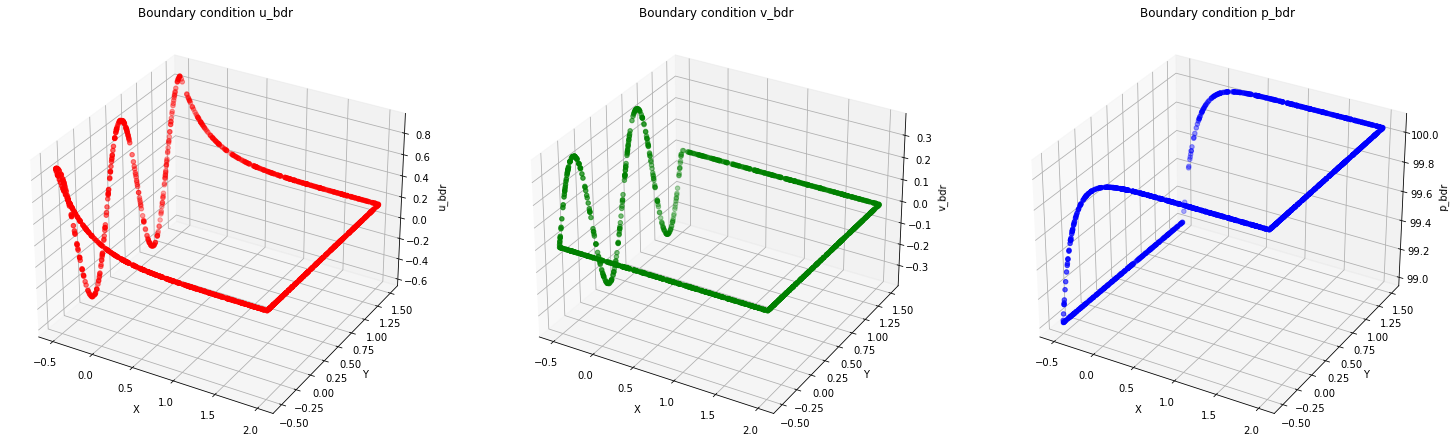

In [ ]:
fig = plt.figure(figsize=(20, 10))

# Plot u_bdr
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter(x_boundary, y_boundary, u_bdr, c='r', marker='o')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('u_bdr')
ax1.set_title('Boundary condition u_bdr')

# Plot v_bdr
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(x_boundary, y_boundary, v_bdr, c='g', marker='o')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('v_bdr')
ax2.set_title('Boundary condition v_bdr')

# Plot p_bdr
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(x_boundary, y_boundary, p_bdr, c='b', marker='o')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('p_bdr')
ax3.set_title('Boundary condition p_bdr')

plt.tight_layout()
plt.subplots_adjust(wspace = 0.2)
plt.show()